In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt \
    -O /tmp/irish-lyrics-eof.txt

--2020-12-25 08:47:47--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘/tmp/irish-lyrics-eof.txt’

/tmp/irish-lyrics-e 100%[===================>]  67.35K  --.-KB/s    in 0.001s  

2020-12-25 08:47:47 (109 MB/s) - ‘/tmp/irish-lyrics-eof.txt’ saved [68970/68970]



In [2]:
tokenizer = Tokenizer()

data = open('/tmp/irish-lyrics-eof.txt').read()

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(tokenizer.word_index)
print(total_words)

{'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10, 'you': 11, 'all': 12, 'was': 13, 'she': 14, 'that': 15, 'on': 16, 'with': 17, 'her': 18, 'but': 19, 'as': 20, 'when': 21, 'love': 22, 'is': 23, 'your': 24, 'it': 25, 'will': 26, 'from': 27, 'by': 28, 'they': 29, 'be': 30, 'are': 31, 'so': 32, 'he': 33, 'old': 34, 'no': 35, 'oh': 36, 'ill': 37, 'at': 38, 'one': 39, 'his': 40, 'there': 41, 'were': 42, 'heart': 43, 'down': 44, 'now': 45, 'we': 46, 'where': 47, 'young': 48, 'never': 49, 'go': 50, 'come': 51, 'then': 52, 'did': 53, 'not': 54, 'said': 55, 'away': 56, 'their': 57, 'sweet': 58, 'them': 59, 'green': 60, 'if': 61, 'take': 62, 'our': 63, 'like': 64, 'night': 65, 'day': 66, 'o': 67, 'out': 68, 'fair': 69, 'this': 70, 'town': 71, 'have': 72, 'can': 73, 'true': 74, 'its': 75, 'thou': 76, 'see': 77, 'dear': 78, 'more': 79, 'theres': 80, 'or': 81, 'had': 82, 'would': 83, 'over': 84, 'hear': 85, 'up': 86, 'ive': 87, 'through': 88, 'home': 89, '

In [3]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [4]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(total_words, 100, input_length=max_sequence_len-1),
  Bidirectional(LSTM(150)),
  Dense(total_words, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.01), 
              metrics='acc')

history = model.fit(xs, ys, epochs=100)

Epoch 1/100
377/377 [==============================] - 13s 10ms/step - loss: 6.8279 - acc: 0.0648
Epoch 2/100
377/377 [==============================] - 4s 10ms/step - loss: 5.7745 - acc: 0.1105
Epoch 3/100
377/377 [==============================] - 4s 10ms/step - loss: 4.7838 - acc: 0.1649
Epoch 4/100
377/377 [==============================] - 4s 10ms/step - loss: 3.8282 - acc: 0.2554
Epoch 5/100
377/377 [==============================] - 4s 10ms/step - loss: 2.9853 - acc: 0.3722
Epoch 6/100
377/377 [==============================] - 4s 10ms/step - loss: 2.3079 - acc: 0.4845
Epoch 7/100
377/377 [==============================] - 4s 10ms/step - loss: 1.8086 - acc: 0.5897
Epoch 8/100
377/377 [==============================] - 4s 10ms/step - loss: 1.4916 - acc: 0.6493
Epoch 9/100
377/377 [==============================] - 4s 10ms/step - loss: 1.3007 - acc: 0.6935
Epoch 10/100
377/377 [==============================] - 4s 10ms/step - loss: 1.0617 - acc: 0.7450
Epoch 11/100
377/377 [======

In [5]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

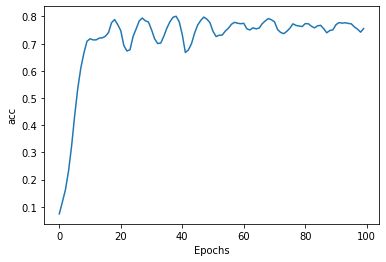

In [7]:
plot_graphs(history, 'acc')


In [8]:
seed_text = "I've got a bad feeling about this"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


I've got a bad feeling about this old times i followed with the spring in the rocky sinking love forever love grows me love im green love im going gone gone nor cannot true be englands cruel daylight agin december in shawl or gown such jewel i fighting fall upon your hapless breast upon them as consumed ever i meet with in shawl or gown struggle or gown and gone my true love is more bright shining clearly till i said sang a bride gone gone away off across a colleen sweet had mary till i required it be mary all the wearin o love is spinning
